In [57]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms


import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint

#importing neural networks
import torch.nn as nn
import torch.nn.functional as func

#import packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dropout, Flatten, BatchNormalization

from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt 
import numpy as np
import os
import h5py
import random as rn
import cmath as cm
from statistics import mean
from matplotlib import rcParams

### Preprocessing Data to generate input for our model (Data and code retrieved from JHU)

In [58]:
# Load Simulated FIDs, which were simulated using FID-A
arrays = {}
f = h5py.File('../DL-FPC/Data for DL-FPC/TrainingData.mat','r')#need to add 'r' mode here to avoid warning
for k, v in f.items():
    arrays[k] = np.array(v)    
FidsOFFtemp = np.transpose(arrays['OFF_fids']) 
FidsONtemp = np.transpose(arrays['ON_fids'])

# Construct the complex FIDs
FidsOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
FidsON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for pp in range(len(FidsOFF[:,0])):
    for kk in range(len(FidsOFF[0,:])):
        FidsOFF[pp,kk] = FidsOFFtemp[pp,kk][0] + 1j * FidsOFFtemp[pp,kk][1] 
        FidsON[pp,kk] = FidsONtemp[pp,kk][0] + 1j * FidsONtemp[pp,kk][1]
     
#Concatenate OFF and ON data - Training is performed using both OFF and ON
Fids = np.concatenate((FidsOFF, FidsON), axis=1)     

# Define Offsets - Randomize 
Phs = np.arange(-90, 90.001, (180/(len(Fids[0])-1)))
F0 = np.arange(-20, 20.0000001, (40/(len(Fids[0])-1))) 
rn.shuffle(Phs) #Randomize
rn.shuffle(F0) #Randomize

#Apply Phase and Frequency Offsets to the simulated FIDs
time = np.arange(2048)/2000

FidsUnAligned = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
FidsUnAlignedPhase = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
spectUnAligned = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
spectUnAlignedPhase = np.empty((len(Fids[:,0]), len(Fids[0,:])), dtype = np.complex_)
for kk in range(len(Fids[0,:])):
   
    phasePart = np.exp(-1j * Phs[kk] * cm.pi / 180)
    freqPart = np.exp(-1j * time * F0[kk] * 2 * cm.pi)
    correction = np.multiply(freqPart,phasePart)
    
    FidsUnAligned[:,kk] = np.multiply(Fids[:,kk], correction) #[2048, 10000]
    FidsUnAlignedPhase[:,kk] = np.multiply(Fids[:,kk], phasePart) #[2048, 10000]
    spectUnAligned[:,kk] = fftshift(fft(FidsUnAligned[:,kk]))
    spectUnAlignedPhase[:,kk] = fftshift(fft(FidsUnAlignedPhase[:,kk]))
    
    scale = np.max(np.squeeze(np.abs(spectUnAligned[:,kk])))
    spectUnAligned[:,kk] = spectUnAligned[:,kk]/np.max(np.squeeze(np.abs(spectUnAligned[:,kk])))

    scalePh = np.max(np.squeeze(np.abs(spectUnAlignedPhase[:,kk])))
    spectUnAlignedPhase[:,kk] = spectUnAlignedPhase[:,kk]/scalePh
    
    # Make Training Data suitable for the networks - 1024 samples
trainingDataF0 = np.absolute(spectUnAligned[512:-512,:])
trainingDataF0 = np.transpose(trainingDataF0) #Transpose to [numSpect 1024]
trainingDataPhase = np.real(spectUnAlignedPhase[512:-512,:])
trainingDataPhase = np.transpose(trainingDataPhase) #Transpose to [numSpect 1024]

In [ ]:
# Make Training Data suitable for the networks - 1024 samples
trainingDataF0 = np.absolute(spectUnAligned[:-512,:])
trainingDataF0 = np.transpose(trainingDataF0) #Transpose to [numSpect 1024]
trainingDataPhase = np.real(spectUnAlignedPhase[512:-512,:])
trainingDataPhase = np.transpose(trainingDataPhase) #Transpose to [numSpect 1024]

In [6]:
#reshaping data
trainingDataF0_cnn=np.expand_dims(trainingDataF0,-1)
trainingDataPhase_cnn=np.expand_dims(trainingDataPhase,-1)

In [491]:
# Validation of networks using simulated data with random offsets.
# Implemented by Sofie Tapper, 2020  

save_model_figurename='./SavedFiguresPaper/figure1A.png'
   
# Define Offsets - Randomize 
PhsOFF = np.arange(-90, 90.0001, (180/(len(FidsOFF[0])-1))) #Take 10000 phase offsets
F0OFF = np.arange(-20, 20.0000001, (40/(len(FidsOFF[0])-1))) #Take 10000 frequency offsets
rn.shuffle(PhsOFF) #Randomize
rn.shuffle(F0OFF) #Randomize

PhsON = np.arange(-90, 90.0001, (180/(len(FidsON[0])-1))) #Take 160 phase offsets
F0ON = np.arange(-20, 20.0000001, (40/(len(FidsON[0])-1))) #Take 160 frequency offsets
rn.shuffle(PhsON) #Randomize
rn.shuffle(F0ON) #Randomize

#Apply Phase and Frequency Offsets to the simulated FIDs
time = np.arange(2048)/2000
FidsUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
FidsUnAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectUnAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)

# define new variables for the deformed on data
FidsUnAlignedON = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedON = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

FidsUnAlignedONPhase =np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedONPhase = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

FidsUnAlignedONFrequency =np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedONFrequency = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

# define new variables for the deformed off data
FidsUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

FidsUnAlignedOFFPhase =np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFFPhase = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

FidsUnAlignedOFFFrequency =np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFFFrequency = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)

for kk in range(len(PhsOFF)):
    
    # on spectra
    # off spectra
    spectAlignedON[:,kk] = fftshift(fft(FidsON[:,kk]))
    
    phasePartON = np.exp(-1j * 25 * cm.pi / 180) # 30 degrees
    freqPartON = np.exp(-1j * time * 10 * 2 * cm.pi) # 20 Hz
    correctionON = np.multiply(phasePartON,freqPartON)
    
    # apply both Freq and Phase offsets
    FidsUnAlignedON[:,kk] = np.multiply(FidsON[:,kk], correctionON) #[2048, 500]
    spectUnAlignedON[:,kk] = fftshift(fft(FidsUnAlignedON[:,kk]))
      
    # apply phase offset
    FidsUnAlignedONPhase[:,kk] = np.multiply(FidsON[:,kk], phasePartON) #[2048, 10000]
    spectUnAlignedONPhase[:,kk] = fftshift(fft(FidsUnAlignedONPhase[:,kk]))
    
    # apply frequency offset
    FidsUnAlignedONFrequency[:,kk] = np.multiply(FidsON[:,kk], freqPartON) #[2048, 10000]
    spectUnAlignedONFrequency[:,kk] = fftshift(fft(FidsUnAlignedONFrequency[:,kk]))
    
    # off spectra
    spectAlignedOFF[:,kk] = fftshift(fft(FidsOFF[:,kk]))
    
    phasePartOFF = np.exp(-1j * 20 * cm.pi / 180) # 30 degrees
    freqPartOFF = np.exp(-1j * time * 9 * 2 * cm.pi) # 20 Hz
    correctionOFF = np.multiply(freqPartOFF,phasePartOFF)
    
    # apply both Freq and Phase offsets
    FidsUnAlignedOFF[:,kk] = np.multiply(FidsOFF[:,kk], correctionOFF) #[2048, 500]
    spectUnAlignedOFF[:,kk] = fftshift(fft(FidsUnAlignedOFF[:,kk]))
      
    # apply Freq offset
    FidsUnAlignedOFFPhase[:,kk] = np.multiply(FidsOFF[:,kk], phasePartOFF) #[2048, 10000]
    spectUnAlignedOFFPhase[:,kk] = fftshift(fft(FidsUnAlignedOFFPhase[:,kk]))
    
    # apply Phase offset
    FidsUnAlignedOFFFrequency[:,kk] = np.multiply(FidsOFF[:,kk], freqPartOFF) #[2048, 10000]
    spectUnAlignedOFFFrequency[:,kk] = fftshift(fft(FidsUnAlignedOFFFrequency[:,kk]))

freqRange = 2000/127.7
ppm = np.flip((np.arange(1,len(FidsOFFtemp[:,0]) + 1)) / len(FidsOFFtemp[:,0]) * freqRange + 4.68 - freqRange/2)
xlim = [1, 4.2]

# on
spectUnAlignedON_real_single = np.mean(spectUnAlignedON[:,1:2].real,1)
spectAlignedON_real_single = np.mean(spectAlignedON[:,1:2].real,1)
spectUnAlignedONFrequency_real_single = np.mean(spectUnAlignedONFrequency[:,1:2].real,1)
spectUnAlignedONPhase_real_single = np.mean(spectUnAlignedONPhase[:,1:2].real,1)

# off
spectUnAlignedOFF_real_single = np.mean(spectUnAlignedOFF[:,1:2].real,1)
spectAlignedOFF_real_single = np.mean(spectAlignedOFF[:,1:2].real,1)
spectUnAlignedOFFFrequency_real_single = np.mean(spectUnAlignedOFFFrequency[:,1:2].real,1)
spectUnAlignedOFFPhase_real_single = np.mean(spectUnAlignedOFFPhase[:,1:2].real,1)

# diff
spectUnAlignedDIFF_real_single = spectUnAlignedON_real_single - spectUnAlignedOFF_real_single
spectAlignedDIFF_real_single = spectAlignedON_real_single - spectAlignedOFF_real_single
spectUnAlignedDIFFFrequency_real_single = spectUnAlignedONFrequency_real_single - spectUnAlignedOFFFrequency_real_single
spectUnAlignedDIFFPhase_real_single = spectUnAlignedONPhase_real_single - spectUnAlignedOFFPhase_real_single


## Training and validation

#### The following code was used to generate our CNN model. The results and analysis using our model can be found from this article:

#### <b>"Magnetic Resonance Spectroscopy Frequency and Phase Correction using Convolutional Neural Networks"<b>
    
For inquiries, please contact djm2249@columbia.edu and jg3400@columbia.edu.



Train on 36000 samples, validate on 4000 samples
Epoch 1/300
36000/36000 [==============================] - 24s 663us/step - loss: 0.5161 - mse: 2.8165 - val_loss: 0.1711 - val_mse: 0.0476

Epoch 00001: val_loss improved from inf to 0.17113, saving model to ./CNNmodel/CNNModel_F0_noNoise.h5
Epoch 2/300
36000/36000 [==============================] - 17s 477us/step - loss: 0.1393 - mse: 0.0331 - val_loss: 0.1472 - val_mse: 0.0329

Epoch 00002: val_loss improved from 0.17113 to 0.14723, saving model to ./CNNmodel/CNNModel_F0_noNoise.h5
Epoch 3/300
36000/36000 [==============================] - 17s 471us/step - loss: 0.1033 - mse: 0.0175 - val_loss: 0.1816 - val_mse: 0.0441

Epoch 00003: val_loss did not improve from 0.14723
Epoch 4/300
36000/36000 [==============================] - 19s 526us/step - loss: 0.0905 - mse: 0.0135 - val_loss: 0.0587 - val_mse: 0.0054

Epoch 00004: val_loss improved from 0.14723 to 0.05868, saving model to ./CNNmodel/CNNModel_F0_noNoise.h5
Epoch 5/300
36000/36

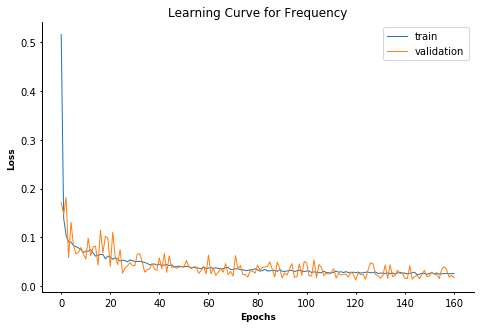

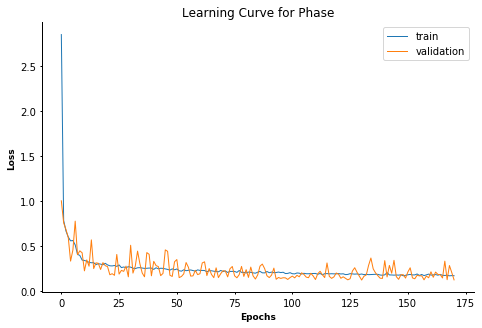

In [7]:
# Define variables for this cell
Input_x1 = trainingDataF0_cnn
GT_y1 = F0
filename1 = 'CNNModel_F0_noNoise.h5'
Input_x2 = trainingDataPhase_cnn
GT_y2 = Phs
filename2 = 'CNNModel_Phs_noNoise.h5'
eepochs = 300


# Create Network Model for F0 Offset Estimation
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=3,padding='same',activation='relu',input_shape=Input_x1.shape[1:]))
model.add(MaxPooling1D(2,2,padding='valid'))
model.add(Conv1D(filters=4, kernel_size=3,padding='same',activation='relu',input_shape=Input_x1.shape[1:]))
model.add(MaxPooling1D(2,2,padding='valid'))
model.add(Flatten())
model.add(Dense(1024,  kernel_initializer='normal', activation = 'relu')) #Fully Connected Layer + ReLu
model.add(Dense(512,  kernel_initializer='normal', activation = 'relu')) #Fully Connected Layer + ReLU
model.add(Dense(1,  kernel_initializer='normal', activation = 'linear')) #Fully Connected Layer + Linear

# Traing Network Model with Validation Earlystopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=40)
mc = ModelCheckpoint('./CNNmodel/'+filename1, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
model.compile(loss='mean_absolute_error', optimizer = 'adam', metrics=['mse'])
hist_F0 = model.fit(Input_x1, GT_y1, validation_split=0.1, epochs=eepochs, callbacks=[es, mc])

# Define variables for this cell

# Create Network Model for F0 Offset Estimation
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=3,padding='same',activation='relu',input_shape=Input_x2.shape[1:]))
model.add(MaxPooling1D(2,2,padding='valid'))
model.add(Conv1D(filters=4, kernel_size=3,padding='same',activation='relu',input_shape=Input_x2.shape[1:]))
model.add(MaxPooling1D(2,2,padding='valid'))
model.add(Flatten())
model.add(Dense(1024,  kernel_initializer='normal', activation = 'relu')) #Fully Connected Layer + ReLu
model.add(Dense(512,  kernel_initializer='normal', activation = 'relu')) #Fully Connected Layer + ReLU
model.add(Dense(1,  kernel_initializer='normal', activation = 'linear')) #Fully Connected Layer + Linear
print(model.summary())

# Traing Network Model with Validation Earlystopping
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=40)
mc = ModelCheckpoint('./CNNmodel/'+filename2, monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
model.compile(loss='mean_absolute_error', optimizer = 'adam', metrics=['mse'])
hist_Ph = model.fit(Input_x2, GT_y2, validation_split=0.1, epochs=eepochs, callbacks=[es, mc])

# %% Plot Results

# Plot Loss During Training - F0
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)  

lw = 1
plt.plot(hist_F0.history['loss'],linewidth=lw, label='train')
plt.plot(hist_F0.history['val_loss'],linewidth=lw, label='validation')
plt.title("Learning Curve for Frequency")
plt.legend()

plt.xlabel('Epochs', fontname="Arial", fontsize=9, fontweight='bold')
ax.tick_params(width=1,color='k',length=2)
plt.ylabel('Loss', fontname="Arial", fontsize=9, fontweight='bold')


plt.subplots_adjust(left=0.2, right=0.95, top=0.95,bottom=0.2)

# Plot Loss During Training - Phase
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)  

lw = 1
plt.plot(hist_Ph.history['loss'],linewidth=lw, label='train')
plt.plot(hist_Ph.history['val_loss'],linewidth=lw, label='validation')
plt.title("Learning Curve for Phase")
plt.legend()


plt.xlabel('Epochs', fontname="Arial", fontsize=9, fontweight='bold')
ax.tick_params(width=1,color='k',length=2)
plt.ylabel('Loss', fontname="Arial", fontsize=9, fontweight='bold')

plt.subplots_adjust(left=0.2, right=0.95, top=0.95,bottom=0.2)

## Evaluating simulated test Set with simulated data (Retrieved code from JHU)

OFF F0: Mean Absolute Error:  0.012852612087691681  +-  0.009565655395667465
ON F0: Mean Absolute Error:  0.01287397687890882  +-  0.010323026680254945
OFF Ph: Mean Absolute Error:  0.12515752623018156  +-  0.09808088235512422
ON Ph: Mean Absolute Error:  0.12266087668605709  +-  0.10250269719051948
$ 0.01 \pm 0.01 \/\degree$
$ 0.12 \pm 0.10 \/\degree$


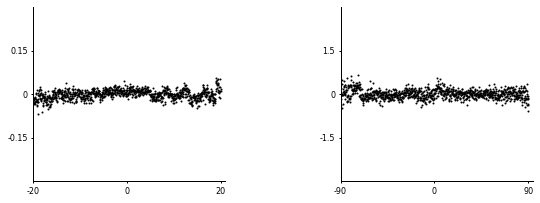

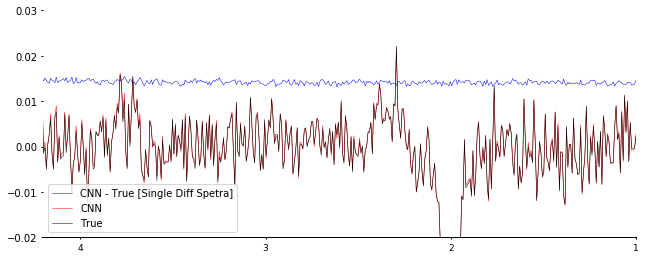

In [24]:
# Validation of networks using simulated data with random offsets.
# Implemented by Sofie Tapper, 2020

#defining variables
model_f='./CNNmodel/CNNModel_F0_noNoise.h5'
model_p='./CNNmodel/CNNModel_Phs_noNoise.h5'
dB=5
seed1=1
seed2=2
save_model_figurename1='./SavedFiguresPaper/NewFigures/cnn_noNoiseScatter.png'
save_model_figurename2='./SavedFiguresPaper/NewFigures/cnn_noNoiseSpectra.png'


os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Load validation data that were simulated using FID-A.
arrays = {}
f = h5py.File('../DL-FPC/Data for DL-FPC/ValidationData.mat','r')
for k, v in f.items():
    arrays[k] = np.array(v)    
    
FidsONtemp = np.transpose(arrays['ON_fids'])
FidsOFFtemp = np.transpose(arrays['OFF_fids'])

# Construct complex FIDs
FidsOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
FidsON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for pp in range(len(FidsON[:,0])):
    for kk in range(len(FidsON[0,:])):
        FidsOFF[pp,kk] = FidsOFFtemp[pp,kk][0] + 1j * FidsOFFtemp[pp,kk][1]  
        FidsON[pp,kk] = FidsONtemp[pp,kk][0] + 1j * FidsONtemp[pp,kk][1]       
   
# Define Offsets - Randomize 
PhsOFF = np.arange(-90, 90.0001, (180/(len(FidsOFF[0])-1))) #Take 10000 phase offsets
F0OFF = np.arange(-20, 20.0000001, (40/(len(FidsOFF[0])-1))) #Take 10000 frequency offsets
rn.shuffle(PhsOFF) #Randomize
rn.shuffle(F0OFF) #Randomize

PhsON = np.arange(-90, 90.0001, (180/(len(FidsON[0])-1))) #Take 160 phase offsets
F0ON = np.arange(-20, 20.0000001, (40/(len(FidsON[0])-1))) #Take 160 frequency offsets
rn.shuffle(PhsON) #Randomize
rn.shuffle(F0ON) #Randomize

#Apply Phase and Frequency Offsets to the simulated FIDs
time = np.arange(2048)/2000
FidsUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectAlignedOFF = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
FidsUnAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectUnAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectAlignedON = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for kk in range(len(PhsOFF)):
    
    spectAlignedOFF[:,kk] = fftshift(fft(FidsOFF[:,kk]))
    
    phasePartOFF = np.exp(-1j * PhsOFF[kk] * cm.pi / 180)
    freqPartOFF = np.exp(-1j * time * F0OFF[kk] * 2 * cm.pi)
    correctionOFF = np.multiply(freqPartOFF,phasePartOFF)
    
    FidsUnAlignedOFF[:,kk] = np.multiply(FidsOFF[:,kk], correctionOFF) #[2048, 500]
    spectUnAlignedOFF[:,kk] = fftshift(fft(FidsUnAlignedOFF[:,kk]))
    
    spectAlignedON[:,kk] = fftshift(fft(FidsON[:,kk]))
    
    phasePartON = np.exp(-1j * PhsON[kk] * cm.pi / 180)
    freqPartON = np.exp(-1j * time * F0ON[kk] * 2 * cm.pi)
    correctionON = np.multiply(freqPartON,phasePartON)
    
    FidsUnAlignedON[:,kk] = np.multiply(FidsON[:,kk], correctionON) #[2048, 500]
    spectUnAlignedON[:,kk] = fftshift(fft(FidsUnAlignedON[:,kk]))
    
    scaleOFF = np.max(np.squeeze(np.abs(spectUnAlignedOFF[:,kk])))
    spectUnAlignedOFF[:,kk] = spectUnAlignedOFF[:,kk]/scaleOFF
    
    scaleON = np.max(np.squeeze(np.abs(spectUnAlignedON[:,kk])))
    spectUnAlignedON[:,kk] = spectUnAlignedON[:,kk]/scaleON

# Make data appropriate for the networks
validationDataOFF = np.absolute(spectUnAlignedOFF[512:-512,:])
validationDataOFF = np.transpose(validationDataOFF)

validationDataON = np.absolute(spectUnAlignedON[512:-512,:])
validationDataON = np.transpose(validationDataON)

#noise addition
signal_freqON=mean(validationDataON[0,:])
signal_freqOFF=mean(validationDataOFF[0,:])

std_freqON=signal_freqON/(10**(dB/20))
std_freqOFF=signal_freqOFF/(10**(dB/20))

np.random.seed(seed1)
noise_low_freqON = np.random.normal(0, std_freqON, validationDataON.shape)
np.random.seed(seed2)
noise_low_freqOFF = np.random.normal(0, std_freqOFF, validationDataOFF.shape)

validationDataON=validationDataON
validationDataOFF=validationDataOFF

validationDataON=np.expand_dims(validationDataON,-1)
validationDataOFF=np.expand_dims(validationDataOFF,-1)


# Load Trained Model - F0 OFF
model = load_model(model_f)
prediction_F0_OFF = model.predict(validationDataOFF)
error_F0_OFF = F0OFF-np.transpose(prediction_F0_OFF)

print("OFF F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_OFF)), " +- ", np.std(np.absolute(error_F0_OFF)))

# Perform Frequency Correction
FidsUnAlignedOFFPhase = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectUnAlignedOFFPhase = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
for kk in range(len(PhsOFF)):
    freqPart = np.exp(1j * time * prediction_F0_OFF[kk] * 2 * cm.pi)
    FidsUnAlignedOFFPhase[:,kk] = np.multiply(FidsUnAlignedOFF[:,kk], freqPart)
    spectUnAlignedOFFPhase[:,kk] = fftshift(fft(FidsUnAlignedOFFPhase[:,kk]))

    scaleOFF = np.max(np.squeeze(np.abs(spectUnAlignedOFFPhase[:,kk])))
    spectUnAlignedOFFPhase[:,kk] = spectUnAlignedOFFPhase[:,kk]/scaleOFF
    
validationDataOFFPhase = np.real(spectUnAlignedOFFPhase[512:-512,:])
validationDataOFFPhase = np.transpose(validationDataOFFPhase)

# The same for ON data
prediction_F0_ON = model.predict(validationDataON)
error_F0_ON = F0ON-np.transpose(prediction_F0_ON)

print("ON F0: Mean Absolute Error: ", np.mean(np.absolute(error_F0_ON)), " +- ", np.std(np.absolute(error_F0_ON)))

# Perform Frequency Correction
FidsUnAlignedONPhase = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectUnAlignedONPhase = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for kk in range(len(PhsON)):
    freqPart = np.exp(1j * time * prediction_F0_ON[kk] * 2 * cm.pi)
    FidsUnAlignedONPhase[:,kk] = np.multiply(FidsUnAlignedON[:,kk], freqPart)
    spectUnAlignedONPhase[:,kk] = fftshift(fft(FidsUnAlignedONPhase[:,kk]))

    scaleON = np.max(np.squeeze(np.abs(spectUnAlignedONPhase[:,kk])))
    spectUnAlignedONPhase[:,kk] = spectUnAlignedONPhase[:,kk]/scaleON

#phase
validationDataONPhase = np.real(spectUnAlignedONPhase[512:-512,:])
validationDataONPhase = np.transpose(validationDataONPhase)

#noise addition
signal_PhsON=mean(validationDataONPhase[0,:])
signal_PhsOFF=mean(validationDataOFFPhase[0,:])

std_PhsON=signal_PhsON/(10**(dB/20))
std_PhsOFF=signal_PhsOFF/(10**(dB/20))

np.random.seed(seed1)
noise_low_PhsON = np.random.normal(0, std_PhsON, validationDataONPhase.shape)
np.random.seed(seed2)
noise_low_PhsOFF = np.random.normal(0, std_PhsOFF, validationDataOFFPhase.shape)

validationDataONPhase=validationDataONPhase
validationDataOFFPhase=validationDataOFFPhase

validationDataONPhase=np.expand_dims(validationDataONPhase,-1)
validationDataOFFPhase=np.expand_dims(validationDataOFFPhase,-1)

# Load Trained Model - Phase
model = load_model(model_p)
prediction_Ph_OFF = model.predict(validationDataOFFPhase)
error_Ph_OFF = PhsOFF-np.transpose(prediction_Ph_OFF)

print("OFF Ph: Mean Absolute Error: ", np.mean(np.absolute(error_Ph_OFF)), " +- ", np.std(np.absolute(error_Ph_OFF)))

# Perform Phase Correction
FidsOFFCorrected = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
spectOFFCorrected = np.empty((len(FidsOFFtemp[:,0]), len(FidsOFFtemp[0,:])), dtype = np.complex_)
for kk in range(len(PhsOFF)):
    phasePart = np.exp(1j * prediction_Ph_OFF[kk] * cm.pi / 180)
    FidsOFFCorrected[:,kk] = np.multiply(FidsUnAlignedOFFPhase[:,kk], phasePart)
    spectOFFCorrected[:,kk] = fftshift(fft(FidsOFFCorrected[:,kk]))

# Load Trained Model - Ph ON
prediction_Ph_ON = model.predict(validationDataONPhase)
error_Ph_ON = PhsON-np.transpose(prediction_Ph_ON)

print("ON Ph: Mean Absolute Error: ", np.mean(np.absolute(error_Ph_ON)), " +- ", np.std(np.absolute(error_Ph_ON)))

# Perform Phase Correction
FidsONCorrected = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
spectONCorrected = np.empty((len(FidsONtemp[:,0]), len(FidsONtemp[0,:])), dtype = np.complex_)
for kk in range(len(PhsON)):
    phasePart = np.exp(1j * prediction_Ph_ON[kk] * cm.pi / 180)
    FidsONCorrected[:,kk] = np.multiply(FidsUnAlignedONPhase[:,kk], phasePart)
    spectONCorrected[:,kk] = fftshift(fft(FidsONCorrected[:,kk]))


# %% Creating the validation figure

fig = plt.figure(figsize=(8.67, 4.4))

ax = plt.subplot(121)   
plt.rc('axes', linewidth=1)

ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=2)
plt.yticks(np.arange(-0.15,0.16, step=0.15),['-0.15','0','0.15'], fontsize=8)
plt.xticks(np.arange(-20,21,step=20),['-20','0','20'], fontsize=8)
plt.xlim((-20,21))
plt.ylim((-0.3, 0.3))
plt.plot(F0OFF, np.squeeze(prediction_F0_OFF) - F0OFF, 'ko', markersize=1)
plt.plot(F0ON, np.squeeze(prediction_F0_ON) - F0ON, 'ko', markersize=1)

t1 = np.mean(np.absolute(np.squeeze(prediction_F0_OFF) - F0OFF))
t2 = np.mean(np.absolute(np.squeeze(prediction_F0_ON) - F0ON))
t3 = (t1 + t2)/2
e1 = np.std(np.absolute(np.squeeze(prediction_F0_OFF) - F0OFF))
e2 = np.std(np.absolute(np.squeeze(prediction_F0_ON) - F0ON))
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))

rcParams['mathtext.default'] = 'regular'
     
ax = plt.subplot(122)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)     
ax.tick_params(width=1,color='k',length=2)
plt.yticks(np.arange(-1.5,1.6,step=1.5),['-1.5','0','1.5'], fontsize=8)
plt.xticks(np.arange(-90,91,step=90),['-90','0','90'], fontsize=8)
plt.xlim((-90,94))
plt.ylim((-3, 3))
plt.plot(PhsOFF, np.squeeze(prediction_Ph_OFF) - PhsOFF, 'ko', markersize=1)
plt.plot(PhsON, np.squeeze(prediction_Ph_ON) - PhsON, 'ko', markersize=1)

t1 = np.mean(np.absolute(np.squeeze(prediction_Ph_OFF) - PhsOFF))
t2 = np.mean(np.absolute(np.squeeze(prediction_Ph_ON) - PhsON))
t3 = (t1 + t2)/2
e1 = np.std(np.absolute(np.squeeze(prediction_Ph_OFF) - PhsOFF))
e2 = np.std(np.absolute(np.squeeze(prediction_Ph_ON) - PhsON))
e3 = (e1 + e2)/2
print(r'$ {0:.2f} \pm {1:.2f} \/\degree$'.format(t3,e3))
plt.subplots_adjust(wspace=0.6,left=0.18, right=0.98, top=0.8, bottom=0.25)
plt.savefig(save_model_figurename1,format='png', dpi=300,bbox_inches='tight')  
    
freqRange = 2000/127.7
ppm = np.flip((np.arange(1,len(FidsOFFtemp[:,0]) + 1)) / len(FidsOFFtemp[:,0]) * freqRange + 4.68 - freqRange/2)
xlim = [1, 4.2]

fig = plt.figure(figsize=(8.67, 4.5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)   
ax.tick_params(width=1,color='k',length=2)
plt.xticks(np.arange(1,5,step=1), fontsize=9)


lw = 0.5

spectONCorrected_real_single = spectONCorrected[:,1].real
spectOFFCorrected_real_single = spectOFFCorrected[:,1].real
spectAlignedON_real_single = spectAlignedON[:,1].real
spectAlignedOFF_real_single = spectAlignedOFF[:,1].real

plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single - (spectAlignedON_real_single - spectAlignedOFF_real_single) + 0.014,'b',linewidth=0.5)
plt.plot(ppm, spectONCorrected_real_single - spectOFFCorrected_real_single,'r',linewidth=lw)
plt.plot(ppm, spectAlignedON_real_single - spectAlignedOFF_real_single,'k',linewidth=lw)
plt.xlim((xlim))
plt.gca().invert_xaxis()
plt.ylim((-0.02,0.03))
plt.legend(['CNN - True [Single Diff Spetra]','CNN','True'],loc="lower left")

plt.subplots_adjust(left=0.03, right=0.98, top=0.95,bottom=0.25)

plt.savefig(save_model_figurename2,format='png', dpi=300,bbox_inches='tight')  

## Residual Computation using Spectra ON and OFF data 

In [8]:
# On Spectra
spectOn_residue = spectONCorrected - spectAlignedON
spectOn_residue_MAE_mean = np.mean(np.mean(np.absolute(spectOn_residue),axis=0))
spectOn_residue_MAE_STD = np.std(np.mean(np.absolute(spectOn_residue),axis=0))
print("On Spectra: Mean Absolute Error: ", spectOn_residue_MAE_mean, " +- ", spectOn_residue_MAE_STD)

# Off Spectra
spectOff_residue = spectOFFCorrected - spectAlignedOFF
spectOff_residue_MAE_mean = np.mean(np.mean(np.absolute(spectOff_residue),axis=0))
spectOff_residue_MAE_STD = np.std(np.mean(np.absolute(spectOff_residue),axis=0))
print("Off Spectra: Mean Absolute Error: ", spectOff_residue_MAE_mean, " +- ", spectOff_residue_MAE_STD)

# Diff Spectra
spectDiff_residue = spectONCorrected - spectOFFCorrected - (spectAlignedON - spectAlignedOFF)
spectDiff_residue_MAE_mean = np.mean(np.mean(np.absolute(spectDiff_residue),axis=0))
spectDiff_residue_MAE_STD = np.std(np.mean(np.absolute(spectDiff_residue),axis=0))
print("Diff Spectra: Mean Absolute Error: ", spectDiff_residue_MAE_mean, " +- ", spectDiff_residue_MAE_STD)

On Spectra: Mean Absolute Error:  0.0002591037117787801  +-  0.00016849566444071946
Off Spectra: Mean Absolute Error:  0.00026126186165098964  +-  0.0001588983843954485
Diff Spectra: Mean Absolute Error:  0.0003971561365461807  +-  0.0001782994241237557
